# IDB_drilling_monitoring

## Import packages

In [1]:
import gc
import IPython
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io as scio
import soundfile
import time
from keras.layers import Activation, BatchNormalization, Concatenate, Conv1D, Conv2D, Dense, Dropout, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D, Input, MaxPooling1D, MaxPooling2D
from keras.models import load_model, Model, Sequential
from keras.utils import to_categorical
from pyts.image import RecurrencePlot, MarkovTransitionField, GramianAngularField
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tqdm import tqdm

!nvidia-smi
HOST_path = "/root/autodl-tmp"

SETS_path = os.path.join(HOST_path, "IDB_drilling_monitoring/datasets")
SAVE_path = os.path.join(HOST_path, "IDB_drilling_monitoring/outputs")

if not os.path.exists(DATA_path):
    os.makedirs(DATA_path)
    
if not os.path.exists(SAVE_path):
    os.makedirs(SAVE_path)

2023-10-22 16:44:18.381486: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Sun Oct 22 16:44:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:32:00.0 Off |                  Off |
| 30%   27C    P8    20W / 450W |      2MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load signal data

In [2]:
def read_wavFile(signal_path):
  signal_rate, signal_value = scio.wavfile.read(signal_path)
  print("signal_shape:", signal_value.shape, "sampling_rate:", signal_rate, "time:", len(signal_value)/signal_rate, "s")
  return signal_value, signal_rate

def read_allFile(signal_path):
    signal_value, signal_rate = librosa.load(signal_path, sr=None, mono=True, offset=0.0, duration=None)
    print("signal_shape:", signal_value.shape, "sampling_rate:", signal_rate, "time:", len(signal_value)/signal_rate, "s")
    # if signal_rate != RATE:
    #     signal_value = librosa.resample(signal_value, orig_sr=signal_rate, target_sr=RATE)
    max_value = np.max(np.abs(signal_value))
    signal_value = signal_value / max_value
    return signal_value, signal_rate

S1, R1 = read_allFile(os.path.join(HOST_path, "IDB_drilling_monitoring/signal/2023-09-17 10.23.02.wav"))
S2, R2 = read_allFile(os.path.join(HOST_path, "IDB_drilling_monitoring/signal/2023-09-17 15.27.17.wav"))
S3, R3 = read_allFile(os.path.join(HOST_path, "IDB_drilling_monitoring/signal/2023-09-17 18.12.28.wav"))

print(S1.shape, R1)
print(S2.shape, R2)
print(S3.shape, R3)

signal_shape: (360744192,) sampling_rate: 48000 time: 7515.504 s
signal_shape: (227191808,) sampling_rate: 48000 time: 4733.162666666667 s
signal_shape: (675086336,) sampling_rate: 48000 time: 14064.298666666667 s
(360744192,) 48000
(227191808,) 48000
(675086336,) 48000


## Plot signal data

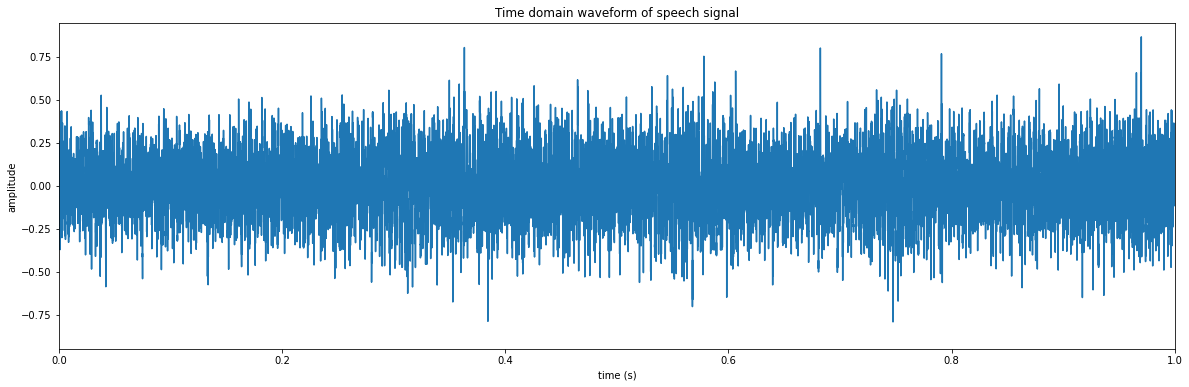

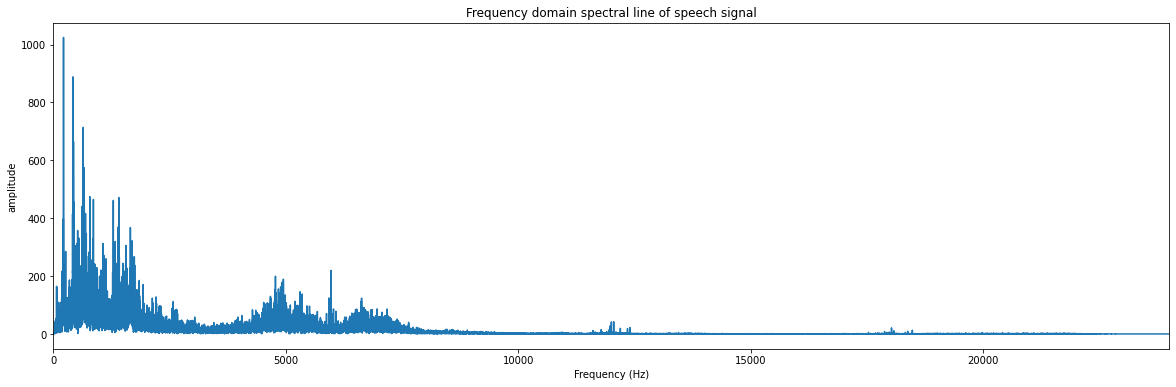

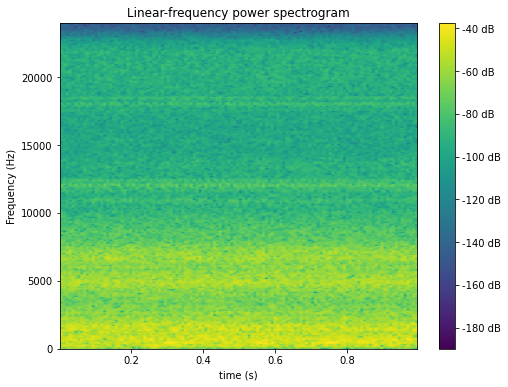

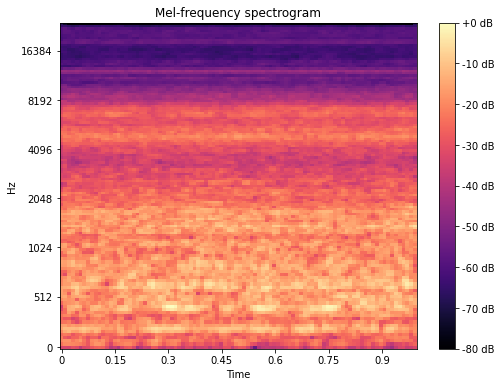

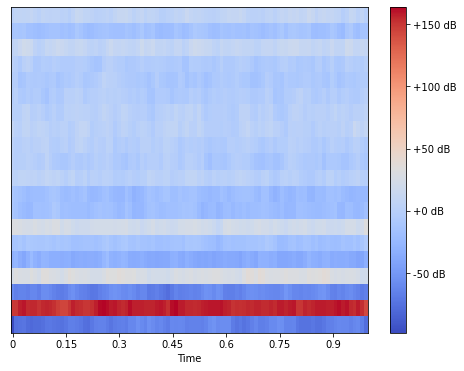

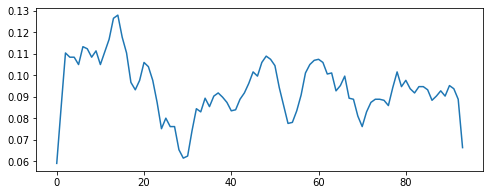

In [3]:
def displayWaveform(signal, rate):
  plt.figure(figsize=(20,6))
  max = np.max(np.absolute(signal))*1.2
  time = np.arange(0, len(SIGNAL)) / RATE
  plt.plot(time, signal)
  plt.title("Time domain waveform of speech signal")
  plt.xlabel("time (s)")
  plt.ylabel("amplitude")
  plt.xlim(0,len(SIGNAL)/RATE)
  ymin, ymax = plt.ylim()
  ylim = np.maximum(np.abs(ymin), np.abs(ymax))
  plt.ylim(-ylim, ylim)

def displaySpectrum(signal, rate):
  plt.figure(figsize=(20,6))
  s = np.fft.fft(signal)
  m = np.abs(s)
  n = len(signal)
  f = np.fft.fftfreq(n, 1/rate)
  plt.plot(f[:n//2],m[:n//2])
  plt.title("Frequency domain spectral line of speech signal")
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("amplitude")
  plt.xlim(0, rate//2)

def displaySpectrogram(signal, rate, fftlen):
  plt.figure(figsize=(8,6))
  plt.specgram(signal, NFFT=fftlen, Fs=rate, noverlap=int(fftlen*0.25), window=np.hanning(fftlen))
  plt.title('Linear-frequency power spectrogram')
  plt.xlabel('time (s)')
  plt.ylabel('Frequency (Hz)')
  plt.colorbar(format="%+2.0f dB")

def displayMelspectrogram(signal, rate):
  plt.figure(figsize=(8,6))
  # melspectrogram = librosa.feature.melspectrogram(y=signal, sr=rate)
  D = np.abs(librosa.stft(signal))**2
  S = librosa.feature.melspectrogram(S=D, sr=rate)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, sr=rate, fmax=rate/2, x_axis='time', y_axis='mel')
  plt.title('Mel-frequency spectrogram')
  plt.colorbar(format='%+2.0f dB')

def diaplayMFCC(signal, rate):
  plt.figure(figsize=(8,6))
  mfccs = librosa.feature.mfcc(y=signal, sr=rate)
  librosa.display.specshow(mfccs, sr=rate, x_axis='time')
  plt.colorbar(format='%+2.0f dB')

def displayZCR(signal, rate):
  plt.figure(figsize=(8,3))
  zcrs = librosa.feature.zero_crossing_rate(signal)
  plt.plot(zcrs[0])

def plot_wave(signal, rate):
  displayWaveform(signal, rate)
  displaySpectrum(signal, rate)
  displaySpectrogram(signal, rate, fftlen=512)
  displayMelspectrogram(signal, rate)
  diaplayMFCC(signal, rate)
  displayZCR(signal, rate)

RATE = R1
SIGNAL = S1[999*RATE:1000*RATE]

plot_wave(SIGNAL, RATE)
IPython.display.Audio(data=SIGNAL, rate=RATE)

## Pick signal data

In [4]:
R01A = S1[82*RATE:247*RATE]
R01B = S1[551*RATE:713*RATE]
R01C = S1[1057*RATE:1227*RATE]
R01D = S1[1472*RATE:1655*RATE]

R02A = S1[3737*RATE:3943*RATE]
R02B = S1[4183*RATE:4383*RATE]
R02C = S1[4591*RATE:4799*RATE]
R02D = S1[5042*RATE:5259*RATE]

R03A = S1[5722*RATE:5981*RATE]
R03B = S1[6209*RATE:6422*RATE]
R03C = S1[6702*RATE:6927*RATE]
R03D = S1[7165*RATE:7443*RATE]

R04A = S2[530*RATE:608*RATE]
R04B = S2[870*RATE:950*RATE]
R04C = S2[1180*RATE:1269*RATE]
R04D = S2[1510*RATE:1604*RATE]

R05A = S2[1952*RATE:2065*RATE]
R05B = S2[2338*RATE:2424*RATE]
R05C = S2[2672*RATE:2790*RATE]
R05D = S2[3020*RATE:3134*RATE]

R06A = S2[3458*RATE:3552*RATE]
R06B = S2[3784*RATE:3877*RATE]
R06C = S2[4092*RATE:4217*RATE]
R06D = S2[4576*RATE:4674*RATE]

R07A = S3[122*RATE:395*RATE]
R07B = S3[668*RATE:885*RATE]
R07C = S3[1105*RATE:1345*RATE]
R07D = S3[1568*RATE:1793*RATE]

R08A = S3[2292*RATE:2523*RATE]
R08B = S3[2785*RATE:3014*RATE]
R08C = S3[3407*RATE:3633*RATE]
R08D = S3[3871*RATE:4113*RATE]

R09A = S3[4413*RATE:4661*RATE]
R09B = S3[4927*RATE:5185*RATE]
R09C = S3[5845*RATE:6134*RATE]
R09D = S3[6372*RATE:6631*RATE]

R10A = S3[8261*RATE:8371*RATE]
R10B = S3[8605*RATE:8756*RATE]
R10C = S3[9063*RATE:9241*RATE]
R10D = S3[9686*RATE:9867*RATE]

R11A = S3[10346*RATE:10536*RATE]
R11B = S3[10761*RATE:10931*RATE]
R11C = S3[11120*RATE:11288*RATE]
R11D = S3[11709*RATE:11923*RATE]

R12A = S3[12421*RATE:12653*RATE]
R12B = S3[12931*RATE:13102*RATE]
R12C = S3[13301*RATE:13545*RATE]
R12D = S3[13744*RATE:14035*RATE]

In [5]:
del S1, S2, S3, R1, R2, R3
gc.collect()

signal_list = ["R01A", "R01B", "R01C", "R01D",
         "R02A", "R02B", "R02C", "R02D",
         "R03A", "R03B", "R03C", "R03D",
         "R04A", "R04B", "R04C", "R04D",
         "R05A", "R05B", "R05C", "R05D",
         "R06A", "R06B", "R06C", "R06D",
         "R07A", "R07B", "R07C", "R07D",
         "R08A", "R08B", "R08C", "R08D",
         "R09A", "R09B", "R09C", "R09D",
         "R10A", "R10B", "R10C", "R10D",
         "R11A", "R11B", "R11C", "R11D",
         "R12A", "R12B", "R12C", "R12D"]

def check_signal():
    for signal in signal_list:
        print(signal, eval(signal).shape, len(eval(signal))/RATE,"s")
check_signal()

R01A (7920000,) 165.0 s
R01B (7776000,) 162.0 s
R01C (8160000,) 170.0 s
R01D (8784000,) 183.0 s
R02A (9888000,) 206.0 s
R02B (9600000,) 200.0 s
R02C (9984000,) 208.0 s
R02D (10416000,) 217.0 s
R03A (12432000,) 259.0 s
R03B (10224000,) 213.0 s
R03C (10800000,) 225.0 s
R03D (13344000,) 278.0 s
R04A (3744000,) 78.0 s
R04B (3840000,) 80.0 s
R04C (4272000,) 89.0 s
R04D (4512000,) 94.0 s
R05A (5424000,) 113.0 s
R05B (4128000,) 86.0 s
R05C (5664000,) 118.0 s
R05D (5472000,) 114.0 s
R06A (4512000,) 94.0 s
R06B (4464000,) 93.0 s
R06C (6000000,) 125.0 s
R06D (4704000,) 98.0 s
R07A (13104000,) 273.0 s
R07B (10416000,) 217.0 s
R07C (11520000,) 240.0 s
R07D (10800000,) 225.0 s
R08A (11088000,) 231.0 s
R08B (10992000,) 229.0 s
R08C (10848000,) 226.0 s
R08D (11616000,) 242.0 s
R09A (11904000,) 248.0 s
R09B (12384000,) 258.0 s
R09C (13872000,) 289.0 s
R09D (12432000,) 259.0 s
R10A (5280000,) 110.0 s
R10B (7248000,) 151.0 s
R10C (8544000,) 178.0 s
R10D (8688000,) 181.0 s
R11A (9120000,) 190.0 s
R11B (8

In [6]:
def load_table(table_path, time_start, time_end):
  SIGNAL_pd = pd.read_excel(table_path)
  # display(SIGNAL_pd)
  SIGNAL_arr = SIGNAL_pd.values[time_start-2+10 : time_end-2-10+1, 1:-1]
  print(type(SIGNAL_arr), SIGNAL_arr.shape, len(SIGNAL_arr)-1, "s")
  # print(SIGNAL_arr)
  return SIGNAL_arr

Y01A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 140, 325)
Y01B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 609, 791)
Y01C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 1115, 1305)
Y01D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 1530, 1733)

Y02A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 3795, 4021)
Y02B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 4241, 4461)
Y02C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 4649, 4877)
Y02D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 5100, 5337)

Y03A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 5780, 6059)
Y03B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 6267, 6500)
Y03C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 6760, 7005)
Y03D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 7223, 7521)

Y04A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 123, 221)
Y04B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 463, 563)
Y04C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 773, 882)
Y04D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 1103, 1217)

Y05A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 1545, 1678)
Y05B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 1931, 2037)
Y05C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 2265, 2403)
Y05D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 2613, 2747)

Y06A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 3051, 3165)
Y06B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 3377, 3490)
Y06C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 3685, 3830)
Y06D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 4169, 4287)

Y07A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 146, 439)
Y07B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 692, 929)
Y07C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 1129, 1389)
Y07D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 1592, 1837)

Y08A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 2316, 2567)
Y08B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 2809, 3058)
Y08C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 3431, 3677)
Y08D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 3895, 4157)

Y09A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 4437, 4705)
Y09B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 4951, 5229)
Y09C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 5869, 6178)
Y09D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 6396, 6675)

Y10A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 8285, 8415)
Y10B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 8629, 8800)
Y10C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 9087, 9285)
Y10D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 9710, 9911)

Y11A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 10370, 10580)
Y11B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 10785, 10975)
Y11C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 11144, 11332)
Y11D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 11733, 11967)

Y12A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 12445, 12697)
Y12B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 12955, 13146)
Y12C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 13325, 13589)
Y12D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 13768, 14079)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (166, 8) 165 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (163, 8) 162 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (171, 8) 170 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (184, 8) 183 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (207, 8) 206 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (201, 8) 200 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (209, 8) 208 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (218, 8) 217 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (260, 8

In [7]:
table_list = ["Y01A", "Y01B", "Y01C", "Y01D",
         "Y02A", "Y02B", "Y02C", "Y02D",
         "Y03A", "Y03B", "Y03C", "Y03D",
         "Y04A", "Y04B", "Y04C", "Y04D",
         "Y05A", "Y05B", "Y05C", "Y05D",
         "Y06A", "Y06B", "Y06C", "Y06D",
         "Y07A", "Y07B", "Y07C", "Y07D",
         "Y08A", "Y08B", "Y08C", "Y08D",
         "Y09A", "Y09B", "Y09C", "Y09D",
         "Y10A", "Y10B", "Y10C", "Y10D",
         "Y11A", "Y11B", "Y11C", "Y11D",
         "Y12A", "Y12B", "Y12C", "Y12D"]

def check_table():
    for table in table_list:
        print(table, eval(table).shape, len(eval(table))-1,"s")
check_table()

Y01A (166, 8) 165 s
Y01B (163, 8) 162 s
Y01C (171, 8) 170 s
Y01D (184, 8) 183 s
Y02A (207, 8) 206 s
Y02B (201, 8) 200 s
Y02C (209, 8) 208 s
Y02D (218, 8) 217 s
Y03A (260, 8) 259 s
Y03B (214, 8) 213 s
Y03C (226, 8) 225 s
Y03D (279, 8) 278 s
Y04A (79, 8) 78 s
Y04B (81, 8) 80 s
Y04C (90, 8) 89 s
Y04D (95, 8) 94 s
Y05A (114, 8) 113 s
Y05B (87, 8) 86 s
Y05C (119, 8) 118 s
Y05D (115, 8) 114 s
Y06A (95, 8) 94 s
Y06B (94, 8) 93 s
Y06C (126, 8) 125 s
Y06D (99, 8) 98 s
Y07A (274, 8) 273 s
Y07B (218, 8) 217 s
Y07C (241, 8) 240 s
Y07D (226, 8) 225 s
Y08A (232, 8) 231 s
Y08B (230, 8) 229 s
Y08C (227, 8) 226 s
Y08D (243, 8) 242 s
Y09A (249, 8) 248 s
Y09B (259, 8) 258 s
Y09C (290, 8) 289 s
Y09D (260, 8) 259 s
Y10A (111, 8) 110 s
Y10B (152, 8) 151 s
Y10C (179, 8) 178 s
Y10D (182, 8) 181 s
Y11A (191, 8) 190 s
Y11B (171, 8) 170 s
Y11C (169, 8) 168 s
Y11D (215, 8) 214 s
Y12A (233, 8) 232 s
Y12B (172, 8) 171 s
Y12C (245, 8) 244 s
Y12D (292, 8) 291 s


In [8]:
def enlarge_value(array, length=RATE):
  L = array.shape[0]
  W = array.shape[1]
  new_section = np.zeros([(L-1)*length, W-1])
  for i in range(L - 1):
    new_second = np.zeros([length, W-1])
    for j in range(W - 1):
      start_value = float(array[i, j+1])
      end_value = float(array[i+1, j+1])
      new_second[:,j] = np.linspace(start_value, end_value, length + 2)[1:-1]
    new_section[i*length:(i+1)*length,:] = new_second
  return new_section

Y01A = enlarge_value(Y01A)
Y01B = enlarge_value(Y01B)
Y01C = enlarge_value(Y01C)
Y01D = enlarge_value(Y01D)
Y02A = enlarge_value(Y02A)
Y02B = enlarge_value(Y02B)
Y02C = enlarge_value(Y02C)
Y02D = enlarge_value(Y02D)
Y03A = enlarge_value(Y03A)
Y03B = enlarge_value(Y03B)
Y03C = enlarge_value(Y03C)
Y03D = enlarge_value(Y03D)
Y04A = enlarge_value(Y04A)
Y04B = enlarge_value(Y04B)
Y04C = enlarge_value(Y04C)
Y04D = enlarge_value(Y04D)
Y05A = enlarge_value(Y05A)
Y05B = enlarge_value(Y05B)
Y05C = enlarge_value(Y05C)
Y05D = enlarge_value(Y05D)
Y06A = enlarge_value(Y06A)
Y06B = enlarge_value(Y06B)
Y06C = enlarge_value(Y06C)
Y06D = enlarge_value(Y06D)
Y07A = enlarge_value(Y07A)
Y07B = enlarge_value(Y07B)
Y07C = enlarge_value(Y07C)
Y07D = enlarge_value(Y07D)
Y08A = enlarge_value(Y08A)
Y08B = enlarge_value(Y08B)
Y08C = enlarge_value(Y08C)
Y08D = enlarge_value(Y08D)
Y09A = enlarge_value(Y09A)
Y09B = enlarge_value(Y09B)
Y09C = enlarge_value(Y09C)
Y09D = enlarge_value(Y09D)
Y10A = enlarge_value(Y10A)
Y10B = enlarge_value(Y10B)
Y10C = enlarge_value(Y10C)
Y10D = enlarge_value(Y10D)
Y11A = enlarge_value(Y11A)
Y11B = enlarge_value(Y11B)
Y11C = enlarge_value(Y11C)
Y11D = enlarge_value(Y11D)
Y12A = enlarge_value(Y12A)
Y12B = enlarge_value(Y12B)
Y12C = enlarge_value(Y12C)
Y12D = enlarge_value(Y12D)

In [9]:
def check_table2():
    for table in table_list:
        print(table, eval(table).shape, len(eval(table))/RATE,"s")
check_table2()

Y01A (7920000, 7) 165.0 s
Y01B (7776000, 7) 162.0 s
Y01C (8160000, 7) 170.0 s
Y01D (8784000, 7) 183.0 s
Y02A (9888000, 7) 206.0 s
Y02B (9600000, 7) 200.0 s
Y02C (9984000, 7) 208.0 s
Y02D (10416000, 7) 217.0 s
Y03A (12432000, 7) 259.0 s
Y03B (10224000, 7) 213.0 s
Y03C (10800000, 7) 225.0 s
Y03D (13344000, 7) 278.0 s
Y04A (3744000, 7) 78.0 s
Y04B (3840000, 7) 80.0 s
Y04C (4272000, 7) 89.0 s
Y04D (4512000, 7) 94.0 s
Y05A (5424000, 7) 113.0 s
Y05B (4128000, 7) 86.0 s
Y05C (5664000, 7) 118.0 s
Y05D (5472000, 7) 114.0 s
Y06A (4512000, 7) 94.0 s
Y06B (4464000, 7) 93.0 s
Y06C (6000000, 7) 125.0 s
Y06D (4704000, 7) 98.0 s
Y07A (13104000, 7) 273.0 s
Y07B (10416000, 7) 217.0 s
Y07C (11520000, 7) 240.0 s
Y07D (10800000, 7) 225.0 s
Y08A (11088000, 7) 231.0 s
Y08B (10992000, 7) 229.0 s
Y08C (10848000, 7) 226.0 s
Y08D (11616000, 7) 242.0 s
Y09A (11904000, 7) 248.0 s
Y09B (12384000, 7) 258.0 s
Y09C (13872000, 7) 289.0 s
Y09D (12432000, 7) 259.0 s
Y10A (5280000, 7) 110.0 s
Y10B (7248000, 7) 151.0 s
Y10

In [10]:
def pick_value(signal, label):
  sample_size = int(RATE/2)
  sample_step = int(sample_size/2)
  sample_data = []
  sample_idx = []
  for i in range((len(signal)-sample_size) // sample_step):
    sample_data.append(signal[i*sample_step : (i*sample_step+sample_size)])
    sample_idx.append(i*sample_step + sample_size//2)
  sample_data = np.stack(sample_data)
  sample_data = np.squeeze(sample_data)
  sample_label = label[sample_idx]
  return sample_data, sample_label

R01A, Y01A = pick_value(R01A, Y01A)
R01B, Y01B = pick_value(R01B, Y01B)
R01C, Y01C = pick_value(R01C, Y01C)
R01D, Y01D = pick_value(R01D, Y01D)
R02A, Y02A = pick_value(R02A, Y02A)
R02B, Y02B = pick_value(R02B, Y02B)
R02C, Y02C = pick_value(R02C, Y02C)
R02D, Y02D = pick_value(R02D, Y02D)
R03A, Y03A = pick_value(R03A, Y03A)
R03B, Y03B = pick_value(R03B, Y03B)
R03C, Y03C = pick_value(R03C, Y03C)
R03D, Y03D = pick_value(R03D, Y03D)
R04A, Y04A = pick_value(R04A, Y04A)
R04B, Y04B = pick_value(R04B, Y04B)
R04C, Y04C = pick_value(R04C, Y04C)
R04D, Y04D = pick_value(R04D, Y04D)
R05A, Y05A = pick_value(R05A, Y05A)
R05B, Y05B = pick_value(R05B, Y05B)
R05C, Y05C = pick_value(R05C, Y05C)
R05D, Y05D = pick_value(R05D, Y05D)
R06A, Y06A = pick_value(R06A, Y06A)
R06B, Y06B = pick_value(R06B, Y06B)
R06C, Y06C = pick_value(R06C, Y06C)
R06D, Y06D = pick_value(R06D, Y06D)
R07A, Y07A = pick_value(R07A, Y07A)
R07B, Y07B = pick_value(R07B, Y07B)
R07C, Y07C = pick_value(R07C, Y07C)
R07D, Y07D = pick_value(R07D, Y07D)
R08A, Y08A = pick_value(R08A, Y08A)
R08B, Y08B = pick_value(R08B, Y08B)
R08C, Y08C = pick_value(R08C, Y08C)
R08D, Y08D = pick_value(R08D, Y08D)
R09A, Y09A = pick_value(R09A, Y09A)
R09B, Y09B = pick_value(R09B, Y09B)
R09C, Y09C = pick_value(R09C, Y09C)
R09D, Y09D = pick_value(R09D, Y09D)
R10A, Y10A = pick_value(R10A, Y10A)
R10B, Y10B = pick_value(R10B, Y10B)
R10C, Y10C = pick_value(R10C, Y10C)
R10D, Y10D = pick_value(R10D, Y10D)
R11A, Y11A = pick_value(R11A, Y11A)
R11B, Y11B = pick_value(R11B, Y11B)
R11C, Y11C = pick_value(R11C, Y11C)
R11D, Y11D = pick_value(R11D, Y11D)
R12A, Y12A = pick_value(R12A, Y12A)
R12B, Y12B = pick_value(R12B, Y12B)
R12C, Y12C = pick_value(R12C, Y12C)
R12D, Y12D = pick_value(R12D, Y12D)

In [11]:
def check_all():
    for i in range(len(signal_list)):
        signal = signal_list[i]
        table = table_list[i]
        print(signal, eval(signal).shape, table, eval(table).shape)
check_all()

R01A (658, 24000) Y01A (658, 7)
R01B (646, 24000) Y01B (646, 7)
R01C (678, 24000) Y01C (678, 7)
R01D (730, 24000) Y01D (730, 7)
R02A (822, 24000) Y02A (822, 7)
R02B (798, 24000) Y02B (798, 7)
R02C (830, 24000) Y02C (830, 7)
R02D (866, 24000) Y02D (866, 7)
R03A (1034, 24000) Y03A (1034, 7)
R03B (850, 24000) Y03B (850, 7)
R03C (898, 24000) Y03C (898, 7)
R03D (1110, 24000) Y03D (1110, 7)
R04A (310, 24000) Y04A (310, 7)
R04B (318, 24000) Y04B (318, 7)
R04C (354, 24000) Y04C (354, 7)
R04D (374, 24000) Y04D (374, 7)
R05A (450, 24000) Y05A (450, 7)
R05B (342, 24000) Y05B (342, 7)
R05C (470, 24000) Y05C (470, 7)
R05D (454, 24000) Y05D (454, 7)
R06A (374, 24000) Y06A (374, 7)
R06B (370, 24000) Y06B (370, 7)
R06C (498, 24000) Y06C (498, 7)
R06D (390, 24000) Y06D (390, 7)
R07A (1090, 24000) Y07A (1090, 7)
R07B (866, 24000) Y07B (866, 7)
R07C (958, 24000) Y07C (958, 7)
R07D (898, 24000) Y07D (898, 7)
R08A (922, 24000) Y08A (922, 7)
R08B (914, 24000) Y08B (914, 7)
R08C (902, 24000) Y08C (902, 7)
R0

## Convert signal data

In [12]:
# 1D original
def wave2wave(X, show):
    if show==1:
        print("waveform: ", X.shape)
    return X

# 1D spectrum
def wave2spectrum(X, show):
    spectrum = np.abs(np.fft.fft(X))
    spectrum = spectrum[0:len(spectrum)//2]
    if show==1:
        print("spectrum: ", spectrum.shape)
    return spectrum

# 2D spectrogram
def wave2spectrogram(X, show):
    spectrogram = np.abs(librosa.stft(X))
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    if show==1:
        print("spectrogram_db: ", spectrogram_db.shape)
    return spectrogram_db

# 2D mfcc
def wave2mfcc(X, show):
    mfccs = librosa.feature.mfcc(y=X, sr=RATE)
    if show==1:
         print("mfccs: ", mfccs.shape)
    return mfccs

# 2D ptp
def wave2ptp(X, show):
    autocorr = np.correlate(X, X, mode='full')
    time_delay = np.argmax(autocorr[len(autocorr)//2:]) + 1
    embedding = np.array([X[:-2*time_delay], X[time_delay:-time_delay]]).T
    if show==1:
        plt.scatter(embedding[:, 0], embedding[:, 1])
        plt.title('Phase Trajectory Plot')
        plt.show()
    return embedding

# 2D urp
def wave2urp(X, show):
    urp = RecurrencePlot(threshold=None)
    X_urp = urp.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_urp, cmap='rainbow', origin='lower')
        plt.title('Unthresholded Recurrence Plot')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_urp

# 2D rp
def wave2rp(X, show):
    rp = RecurrencePlot(threshold='point', percentage=20)
    X_rp = rp.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_rp, cmap='binary', origin='lower')
        plt.title('Recurrence Plot')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_rp

#2D mtf
def wave2mtf(X, show):
    mtf = MarkovTransitionField(image_size=227)
    X_mtf = mtf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_mtf, cmap='rainbow', origin='lower')
        plt.title('Markov Transition Field')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_mtf

# 2D ga(s)f
def wave2gasf(X, show):
    gasf = GramianAngularField(image_size=227, method='summation')
    X_gasf = gasf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_gasf, cmap='rainbow', origin='lower')
        plt.title('Gramian Angular Summation Fields')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_gasf

# 2D ga(d)f
def wave2gadf(X, show):
    gadf = GramianAngularField(image_size=227, method='difference')
    X_gadf = gadf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_gadf, cmap='rainbow', origin='lower')
        plt.title('Gramian Angular Difference Fields')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_gadf

In [13]:
# SIGNAL = SIGNAL
# print("signal shape: ", SIGNAL.shape)
# wave2wave(SIGNAL, 1)
# wave2spectrum(SIGNAL, 1)
# wave2spectrogram(SIGNAL, 1)
# wave2mfcc(SIGNAL, 1)
# wave2ptp(SIGNAL, 1)
# wave2urp(SIGNAL, 1)
# wave2rp(SIGNAL, 1)
# wave2mtf(SIGNAL, 1)
# wave2gasf(SIGNAL, 1)
# wave2gadf(SIGNAL, 1)

# SIGNAL = SIGNAL[0:227]
# print("signal shape: ", SIGNAL.shape)
# wave2wave(SIGNAL, 1)
# wave2spectrum(SIGNAL, 1)
# wave2spectrogram(SIGNAL, 1)
# wave2mfcc(SIGNAL, 1)
# wave2ptp(SIGNAL, 1)
# wave2urp(SIGNAL, 1)
# wave2rp(SIGNAL, 1)
# wave2mtf(SIGNAL, 1)
# wave2gasf(SIGNAL, 1)
# wave2gadf(SIGNAL, 1)

In [14]:
def wave2others(signals):
    function = wave2spectrum
    results = []
    if function == wave2rp or function == wave2urp:
        random.seed(42)
        shorter_length = 227
        for signal in tqdm(signals):
            shorter_arrays = [signal[i:i+shorter_length] for i in range(len(signal) - shorter_length + 1)]
            signal = random.choice(shorter_arrays)
            result = wave2spectrum(signal, 0)
            result = function(signal, 0)
            results.append(result)
    else:
        for signal in tqdm(signals):
            result = wave2spectrum(signal, 0)
            result = function(signal, 0)
            results.append(result)
    results = np.array(results)
    return results

R01A = wave2others(R01A)
R01B = wave2others(R01B)
R01C = wave2others(R01C)
R01D = wave2others(R01D)

R02A = wave2others(R02A)
R02B = wave2others(R02B)
R02C = wave2others(R02C)
R02D = wave2others(R02D)

R03A = wave2others(R03A)
R03B = wave2others(R03B)
R03C = wave2others(R03C)
R03D = wave2others(R03D)

R04A = wave2others(R04A)
R04B = wave2others(R04B)
R04C = wave2others(R04C)
R04D = wave2others(R04D)

R05A = wave2others(R05A)
R05B = wave2others(R05B)
R05C = wave2others(R05C)
R05D = wave2others(R05D)

R06A = wave2others(R06A)
R06B = wave2others(R06B)
R06C = wave2others(R06C)
R06D = wave2others(R06D)

R07A = wave2others(R07A)
R07B = wave2others(R07B)
R07C = wave2others(R07C)
R07D = wave2others(R07D)

R08A = wave2others(R08A)
R08B = wave2others(R08B)
R08C = wave2others(R08C)
R08D = wave2others(R08D)

R09A = wave2others(R09A)
R09B = wave2others(R09B)
R09C = wave2others(R09C)
R09D = wave2others(R09D)

R10A = wave2others(R10A)
R10B = wave2others(R10B)
R10C = wave2others(R10C)
R10D = wave2others(R10D)

R11A = wave2others(R11A)
R11B = wave2others(R11B)
R11C = wave2others(R11C)
R11D = wave2others(R11D)

R12A = wave2others(R12A)
R12B = wave2others(R12B)
R12C = wave2others(R12C)
R12D = wave2others(R12D)

check_all()

100%|██████████| 1162/1162 [00:01<00:00, 946.19it/s]

R01A (658, 12000) Y01A (658, 7)
R01B (646, 12000) Y01B (646, 7)
R01C (678, 12000) Y01C (678, 7)
R01D (730, 12000) Y01D (730, 7)
R02A (822, 12000) Y02A (822, 7)
R02B (798, 12000) Y02B (798, 7)
R02C (830, 12000) Y02C (830, 7)
R02D (866, 12000) Y02D (866, 7)
R03A (1034, 12000) Y03A (1034, 7)
R03B (850, 12000) Y03B (850, 7)
R03C (898, 12000) Y03C (898, 7)
R03D (1110, 12000) Y03D (1110, 7)
R04A (310, 12000) Y04A (310, 7)
R04B (318, 12000) Y04B (318, 7)
R04C (354, 12000) Y04C (354, 7)
R04D (374, 12000) Y04D (374, 7)
R05A (450, 12000) Y05A (450, 7)
R05B (342, 12000) Y05B (342, 7)
R05C (470, 12000) Y05C (470, 7)
R05D (454, 12000) Y05D (454, 7)
R06A (374, 12000) Y06A (374, 7)
R06B (370, 12000) Y06B (370, 7)
R06C (498, 12000) Y06C (498, 7)
R06D (390, 12000) Y06D (390, 7)
R07A (1090, 12000) Y07A (1090, 7)
R07B (866, 12000) Y07B (866, 7)
R07C (958, 12000) Y07C (958, 7)
R07D (898, 12000) Y07D (898, 7)
R08A (922, 12000) Y08A (922, 7)
R08B (914, 12000) Y08B (914, 7)
R08C (902, 12000) Y08C (902, 7)
R0

## Regression

### Data pre-treatment

In [15]:
X_set = np.concatenate((R01A, R01B, R01C, R01D, R02A, R02B, R02C, R02D, R03A, R03B, R03C, R03D, 
                        R04A, R04B, R04C, R04D, R05A, R05B, R05C, R05D, R06A, R06B, R06C, R06D, 
                        R07A, R07B, R07C, R07D, R08A, R08B, R08C, R08D, R09A, R09B, R09C, R09D, 
                        R10A, R10B, R10C, R10D, R11A, R11B, R11C, R11D, R12A, R12B, R12C, R12D), axis=0)
X_set_cnn = X_set.reshape((X_set.shape[0], X_set.shape[1], 1))
Y_set = np.concatenate((Y01A, Y01B, Y01C, Y01D, Y02A, Y02B, Y02C, Y02D, Y03A, Y03B, Y03C, Y03D, 
                        Y04A, Y04B, Y04C, Y04D, Y05A, Y05B, Y05C, Y05D, Y06A, Y06B, Y06C, Y06D, 
                        Y07A, Y07B, Y07C, Y07D, Y08A, Y08B, Y08C, Y08D, Y09A, Y09B, Y09C, Y09D, 
                        Y10A, Y10B, Y10C, Y10D, Y11A, Y11B, Y11C, Y11D, Y12A, Y12B, Y12C, Y12D), axis=0)

print(X_set.shape)
print(X_set_cnn.shape)
print(Y_set.shape)

np.save(os.path.join(SETS_path, "X_set.npy"), X_set)
np.save(os.path.join(SETS_path, "Y_set.npy"), Y_set)
np.save(os.path.join(SETS_path, "X_set_cnn.npy"), X_set_cnn)

(35524, 12000)
(35524, 12000, 1)
(35524, 7)


In [16]:
del R01A, R01B, R01C, R01D, R02A, R02B, R02C, R02D, R03A, R03B, R03C, R03D
del R04A, R04B, R04C, R04D, R05A, R05B, R05C, R05D, R06A, R06B, R06C, R06D
del R07A, R07B, R07C, R07D, R08A, R08B, R08C, R08D, R09A, R09B, R09C, R09D
del R10A, R10B, R10C, R10D, R11A, R11B, R11C, R11D, R12A, R12B, R12C, R12D
del Y01A, Y01B, Y01C, Y01D, Y02A, Y02B, Y02C, Y02D, Y03A, Y03B, Y03C, Y03D
del Y04A, Y04B, Y04C, Y04D, Y05A, Y05B, Y05C, Y05D, Y06A, Y06B, Y06C, Y06D
del Y07A, Y07B, Y07C, Y07D, Y08A, Y08B, Y08C, Y08D, Y09A, Y09B, Y09C, Y09D
del Y10A, Y10B, Y10C, Y10D, Y11A, Y11B, Y11C, Y11D, Y12A, Y12B, Y12C, Y12D

gc.collect()

57747

In [17]:
ALL7 = Y_set
ALL6 = np.delete(Y_set, 0 ,axis=1)
HEIGHT = np.array([row[0] for row in Y_set])
RPM = np.array([row[1] for row in Y_set])
TORQUE = np.array([row[2] for row in Y_set])
PUMPR = np.array([row[3] for row in Y_set])
PUMPP = np.array([row[4] for row in Y_set])
ROP = np.array([row[5] for row in Y_set])
WOB = np.array([row[6] for row in Y_set])

print(HEIGHT.shape)
print(RPM.shape)
print(TORQUE.shape)
print(PUMPR.shape)
print(PUMPP.shape)
print(ROP.shape)
print(WOB.shape)

np.save(os.path.join(SETS_path, "HEIGHT.npy"), HEIGHT)
np.save(os.path.join(SETS_path, "RPM.npy"), RPM)
np.save(os.path.join(SETS_path, "TORQUE.npy"), TORQUE)
np.save(os.path.join(SETS_path, "PUMPR.npy"), PUMPR)
np.save(os.path.join(SETS_path, "PUMPP.npy"), PUMPP)
np.save(os.path.join(SETS_path, "ROP.npy"), ROP)
np.save(os.path.join(SETS_path, "WOB.npy"), WOB)

(35524,)
(35524,)
(35524,)
(35524,)
(35524,)
(35524,)
(35524,)


In [18]:
INPUT = X_set_cnn
OUTPUT = ALL6 

if OUTPUT.ndim == 1:
    num_targets = 1
else:
    num_targets = OUTPUT.shape[1]

x_train, x_test, y_train, y_test = train_test_split(INPUT, OUTPUT, test_size=0.25, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(num_targets)
 
# np.save(os.path.join(SAVE_path, "x_train.npy"), x_train)
# np.save(os.path.join(SAVE_path, "x_test.npy"), x_test)
# np.save(os.path.join(SAVE_path, "y_train.npy"), y_train)
# np.save(os.path.join(SAVE_path, "y_test.npy"), y_test)

(26643, 12000, 1)
(26643, 6)
(8881, 12000, 1)
(8881, 6)
6


### Model establishment

In [19]:
def make_cnn_model():
    model = Sequential()
    model.add(Conv1D(64, 3, input_shape=x_train.shape[1:], padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(64, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(128, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(128, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(256, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(256, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(256, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(512, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(512, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(512, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(512, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(512, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(512, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4096))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_targets, activation='linear'))
    return model

time0 = time.time()
model = make_cnn_model()
time1 = time.time()
model.summary()

2023-10-22 16:45:58.904763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 16:45:59.396661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22128 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:32:00.0, compute capability: 8.9


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12000, 64)         256       
                                                                 
 batch_normalization (BatchN  (None, 12000, 64)        256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 12000, 64)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 12000, 64)         12352     
                                                                 
 batch_normalization_1 (Batc  (None, 12000, 64)        256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 12000, 64)         0

### Complete & Train

In [ ]:
time2 = time.time()
model.compile(optimizer='adam', loss='mse')
callbacks = [
             keras.callbacks.ModelCheckpoint(os.path.join(SAVE_path, "best_model.hdf5"),
                                             monitor="val_loss",
                                             verbose = 1,
                                             mode="min",
                                             save_best_only=True),
             # keras.callbacks.EarlyStopping(monitor="val_loss",
             #                               mode="min",
             #                               verbose=1,
             #                               patience=10,
             #                               restore_best_weights=True),
             # keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
             #                                   factor=0.2,
             #                                   patience=2,
             #                                   min_lr=0.000001),
             # keras.callbacks.TensorBoard(log_dir=os.path.join(SAVE_path, "R_logs"),
             #                             histogram_freq=1,
             #                             write_graph=True,
             #                             write_images=True),
             ]
history = model.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=callbacks,
                    shuffle=True)
time3 = time.time()

### Show model results

In [ ]:
time4 = time.time()
y_test_pred = model.predict(x_test)
time5 = time.time()
test_loss = model.evaluate(x_test, y_test)
time6 = time.time()

print("Build time:", time1-time0)
print("Train time:", time3-time2)
print("Predict time:", time5-time4)
print("Process time:", time6-time5)
print("Function time:", time6-time4)

### Save model results

In [ ]:
model.save(os.path.join(SAVE_path, "model.hdf5"))
np.save(os.path.join(SAVE_path, "history.npy"), history.history)

### Plot model results

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Test set'], loc='upper left')
plt.savefig(os.path.join(SAVE_path, "loss.png"))
plt.show()

### Evaluate model performance

In [ ]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print(y_train.shape)
print(y_test.shape)
print(y_train_pred.shape)
print(y_test_pred.shape)

print("MAE =", mean_absolute_error(y_test,y_test_pred))         # 残差绝对值
print("MSE =", mean_squared_error(y_test, y_test_pred))         # 通过平方放大了残差
print("RMSE=", np.sqrt(mean_squared_error(y_test,y_test_pred))) # 通过开方，还原被放大残差
print("R^2 =", r2_score(y_test,y_test_pred))                    # R2是相对比例值

# np.save(os.path.join(SAVE_path, "y_train_pred.npy"), y_train_pred)
# np.save(os.path.join(SAVE_path, "y_test_pred.npy"), y_test_pred)

In [ ]:
if num_targets != 1:
    for i in range(num_targets):
        print("index: ", str(i+1))
        print("MAE =", mean_absolute_error(y_test[:,i],y_test_pred[:,i]))         
        print("MSE =", mean_squared_error(y_test[:,i], y_test_pred[:,i]))         
        print("RMSE=", np.sqrt(mean_squared_error(y_test[:,i],y_test_pred[:,i]))) 
        print("R^2 =", r2_score(y_test[:,i],y_test_pred[:,i]))                    

In [ ]:
def plot_curve(i):
    plt.figure(figsize=(5,5))
    plt.scatter(y_test[:,i], y_test_pred[:,i], s=20, edgecolor="black",c="darkorange", label="data")
    xlim = plt.xlim()
    ylim = plt.ylim()
    MIN = min(xlim[0], ylim[0])
    MAX = max(xlim[1], ylim[1])
    plt.xlim(MIN, MAX)
    plt.ylim(MIN, MAX)
    plt.title(str(i))

In [ ]:
if num_targets != 1:
    for i in range(num_targets):
        plot_curve(i)
else:
    plt.figure(figsize=(5,5))
    plt.scatter(y_test, y_test_pred, s=20, edgecolor="black",c="darkorange", label="data")

## Load saved model

In [ ]:
# LOAD_path = SAVE_path

In [ ]:
# x_train = np.load(os.path.join(LOAD_path, "x_train.npy"))
# x_test = np.save(os.path.join(LOAD_path, "x_test.npy"))
# y_train = np.load(os.path.join(LOAD_path, "y_train.npy"))
# y_test = np.save(os.path.join(LOAD_path, "y_test.npy"))
# y_train_pred = np.save(os.path.join(LOAD_path, "y_train_pred.npy") )
# y_test_pred = np.save(os.path.join(LOAD_path, "y_test_pred.npy"))

In [ ]:
# model = load_model(os.path.join(LOAD_path, "model.hdf5"))
# hist = np.load(os.path.join(LOAD_path, "history.npy"), allow_pickle=True).item()

In [ ]:
# plt.plot(hist['loss'])
# plt.plot(hist['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train set', 'Test set'], loc='upper left')
# plt.show()